<a href="https://colab.research.google.com/github/Lxyyxxx/Colab/blob/main/REINFORCE_Baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install loguru

In [2]:
import tensorflow as tf
import gym
import matplotlib.pyplot as plt
from loguru import logger
from typing import Any

In [3]:
class REINFORCEModel(tf.keras.Model):
    def __init__(self, action_n: int) -> None:
        super().__init__()
        self.nn = [
            tf.keras.layers.Dense(30, activation='relu'),
            tf.keras.layers.Dense(30, activation='relu'),
            tf.keras.layers.Dense(action_n, activation='softmax'),
        ]

    def call(self, state: Any) -> Any:
        p = state
        for layer in self.nn:
            p = layer(p)
        return p

In [4]:
class BaselineModel(tf.keras.Model):
    def __init__(self, action_n: int) -> None:
        super().__init__()
        self.nn = [
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(action_n),
        ]

    def call(self, state: Any) -> Any:
        q = state
        for layer in self.nn:
            q = layer(q)
        return q

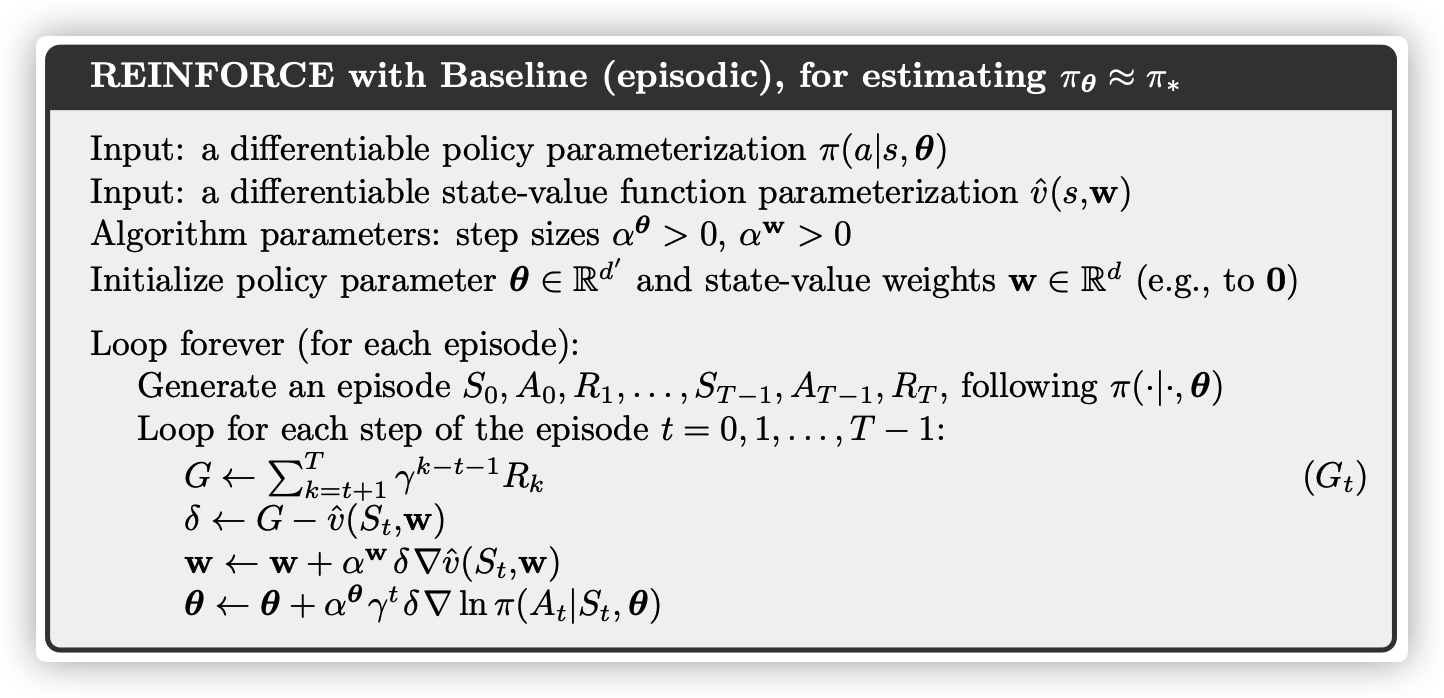

In [5]:
class REINFORCEAgent():
    def __init__(
        self,
        action_n: int,
        alpha_q: float = 0.1,
        alpha_p: float = 0.01,
        gamma: float = 0.9,
    ) -> None:
        self.action_n = action_n
        self.alpha_q = alpha_q
        self.alpha_p = alpha_p
        self.gamma = gamma
        self.model = REINFORCEModel(action_n)
        self.baseline = BaselineModel(action_n)

    def predict(self, state: Any) -> int:
        state = tf.expand_dims(tf.convert_to_tensor(state), 0)
        action = tf.argmax(self.model(state), axis=1).numpy()[0]
        return action

    def learn(self, t: int, state: Any, action: int, G: float) -> None:
        state = tf.expand_dims(tf.convert_to_tensor(state), 0)
        one_hot_actions = tf.one_hot([action], self.action_n)
        # baseline
        td_error = G - tf.reduce_sum(tf.multiply(one_hot_actions, self.baseline(state)), axis=1).numpy()
        with tf.GradientTape() as tape:
            q_loss = tf.reduce_sum(tf.multiply(one_hot_actions, self.baseline(state)), axis=1)
        q_grads = tape.gradient(q_loss, self.baseline.trainable_weights)
        for v, g in zip(self.baseline.trainable_weights, q_grads):
            v.assign_add(self.alpha_q * td_error * g)
        # reinforce
        with tf.GradientTape() as tape:
            policy = tf.reduce_sum(tf.multiply(one_hot_actions, self.model(state)), axis=1)
            p_loss = tf.math.log(policy)
        p_grads = tape.gradient(p_loss, self.model.trainable_weights)
        for v, g in zip(self.model.trainable_weights, p_grads):
            v.assign_add(self.alpha_p * self.gamma ** t * td_error * g)

    def update_target(self) -> None:
        self.target_model.set_weights(self.model.get_weights())

    def save_model(self) -> None:
        self.model.save('reinforce')

    def load_model(self) -> None:
        self.model = tf.keras.models.load_model('reinforce')

In [6]:
def run_episode(env: gym.Wrapper, agent: REINFORCEAgent, training: bool, render: bool = False) -> float:
    state = env.reset()
    done = False
    step = 0
    score = 0
    rewards = []
    states = []
    actions = []
    # trajectory
    while not done:
        if render:
            env.render()
        step += 1
        action = agent.predict(state)
        state_, reward, done, info = env.step(action)
        score += reward
        rewards.append(reward)
        states.append(state)
        actions.append(action)
        state = state_
    # update
    if training:
        T = len(rewards)
        for t, (s, a, r) in enumerate(zip(states, actions, rewards)):
            # G
            G = 0
            for k in range(t + 1, T + 1):
                G += agent.gamma ** (k-t-1) * rewards[k-1]
            # theta
            agent.learn(t, s, a, G)
    return score

In [7]:
def train(env: gym.Wrapper, agent: REINFORCEAgent) -> None:
    score_result = []
    max_score = 0
    for episode in range(1000):
        score = run_episode(env, agent, training=True)
        score_result.append(score)
        if score > max_score:
            max_score = score
            logger.info('Episode {}: Best score {}'.format(episode, score))
        if score == max_score:
            agent.save_model()
        if episode % 50 == 0:
            logger.info('Episode {}: score {}'.format(episode, score))

    plt.title('Train Score Curve')
    plt.xlabel('Episode')
    plt.ylabel('Score')
    plt.plot(score_result, label='$Score$')
    plt.legend()
    plt.show()


def play(env: gym.Wrapper, agent: REINFORCEAgent) -> None:
    score_result = []
    agent.load_model()
    for episode in range(5):
        score = run_episode(env, agent, training=False, render=False)
        score_result.append(score)
        logger.info('Round {}: score: {}'.format(episode, score))

    plt.title('Play Score Curve')
    plt.xlabel('Round')
    plt.ylabel('Score')
    plt.plot(score_result, label='$Score$')
    plt.legend()
    plt.show()

2021-10-03 04:52:09.945 | INFO     | __main__:train:9 - Episode 0: Best score 15.0


INFO:tensorflow:Assets written to: reinforce/assets


2021-10-03 04:52:10.546 | INFO     | __main__:train:13 - Episode 0: score 15.0
2021-10-03 04:52:11.018 | INFO     | __main__:train:9 - Episode 4: Best score 16.0


INFO:tensorflow:Assets written to: reinforce/assets


2021-10-03 04:52:12.171 | INFO     | __main__:train:9 - Episode 10: Best score 20.0


INFO:tensorflow:Assets written to: reinforce/assets


2021-10-03 04:52:12.818 | INFO     | __main__:train:9 - Episode 11: Best score 26.0


INFO:tensorflow:Assets written to: reinforce/assets


2021-10-03 04:52:13.904 | INFO     | __main__:train:9 - Episode 14: Best score 29.0


INFO:tensorflow:Assets written to: reinforce/assets


2021-10-03 04:52:14.663 | INFO     | __main__:train:9 - Episode 15: Best score 38.0


INFO:tensorflow:Assets written to: reinforce/assets


2021-10-03 04:52:15.751 | INFO     | __main__:train:9 - Episode 16: Best score 82.0


INFO:tensorflow:Assets written to: reinforce/assets


2021-10-03 04:52:19.180 | INFO     | __main__:train:9 - Episode 23: Best score 140.0


INFO:tensorflow:Assets written to: reinforce/assets


2021-10-03 04:52:29.960 | INFO     | __main__:train:13 - Episode 50: score 38.0
2021-10-03 04:52:42.022 | INFO     | __main__:train:9 - Episode 80: Best score 151.0


INFO:tensorflow:Assets written to: reinforce/assets


2021-10-03 04:52:50.673 | INFO     | __main__:train:13 - Episode 100: score 44.0
2021-10-03 04:53:11.061 | INFO     | __main__:train:13 - Episode 150: score 74.0
2021-10-03 04:53:32.199 | INFO     | __main__:train:13 - Episode 200: score 42.0
2021-10-03 04:53:51.872 | INFO     | __main__:train:13 - Episode 250: score 30.0
2021-10-03 04:54:19.483 | INFO     | __main__:train:13 - Episode 300: score 132.0
2021-10-03 04:54:41.584 | INFO     | __main__:train:13 - Episode 350: score 58.0
2021-10-03 04:54:56.657 | INFO     | __main__:train:9 - Episode 381: Best score 200.0


INFO:tensorflow:Assets written to: reinforce/assets


2021-10-03 04:55:05.017 | INFO     | __main__:train:13 - Episode 400: score 40.0
2021-10-03 04:55:26.590 | INFO     | __main__:train:13 - Episode 450: score 31.0
2021-10-03 04:55:47.578 | INFO     | __main__:train:13 - Episode 500: score 40.0
2021-10-03 04:56:08.605 | INFO     | __main__:train:13 - Episode 550: score 30.0


INFO:tensorflow:Assets written to: reinforce/assets


2021-10-03 04:56:32.722 | INFO     | __main__:train:13 - Episode 600: score 33.0
2021-10-03 04:56:57.899 | INFO     | __main__:train:13 - Episode 650: score 40.0
2021-10-03 04:57:21.915 | INFO     | __main__:train:13 - Episode 700: score 88.0
2021-10-03 04:57:43.874 | INFO     | __main__:train:13 - Episode 750: score 35.0
2021-10-03 04:58:06.167 | INFO     | __main__:train:13 - Episode 800: score 43.0
2021-10-03 04:58:31.653 | INFO     | __main__:train:13 - Episode 850: score 85.0
2021-10-03 04:58:55.933 | INFO     | __main__:train:13 - Episode 900: score 91.0
2021-10-03 04:59:17.482 | INFO     | __main__:train:13 - Episode 950: score 31.0


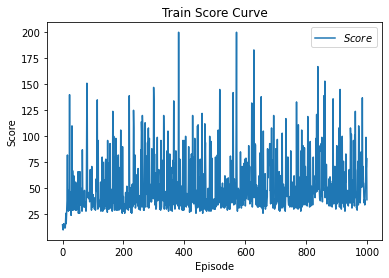

2021-10-03 04:59:42.461 | INFO     | __main__:play:29 - Round 0: score: 82.0
2021-10-03 04:59:42.572 | INFO     | __main__:play:29 - Round 1: score: 115.0
2021-10-03 04:59:42.610 | INFO     | __main__:play:29 - Round 2: score: 38.0
2021-10-03 04:59:42.643 | INFO     | __main__:play:29 - Round 3: score: 31.0
2021-10-03 04:59:42.763 | INFO     | __main__:play:29 - Round 4: score: 126.0


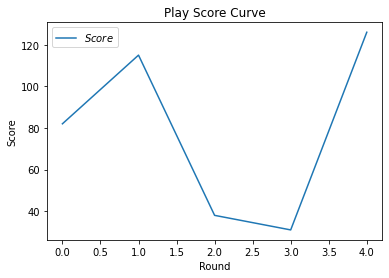

In [8]:
if __name__ == '__main__':
    env = gym.make('CartPole-v0')
    agent = REINFORCEAgent(env.action_space.n)
    # train
    train(env, agent)
    # play
    play(env, agent)